In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import json
import re

dist_results_path = "../data/cloud_logs/dist_res.csv"

# standard machine types
MASTER_MACHINE_TYPE = 'n1-standard-2' # dual core
WORKER_MACHINE_TYPE = 'n1-standard-4' # quad core

versions_res = [
    "Result (JSON) - 1",
    "Result (JSON) - cache code - 2",
    "Result (JSON) - cache + less features + optimizations - 3",
    "Result (JSON) - cache + less features + optimizations + entropy - 4"
    ]

seq_par_results_dir = "../data/logs/"

plots_dir= "../plots/report/"

In [2]:
featFormats = ["Format.Continuous", "Format.Continuous", "Format.Categorical", "Format.Continuous", "Format.Continuous", "Format.Continuous", "Format.Continuous",
  "Format.Continuous", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Continuous", "Format.Categorical",
  "Format.Continuous", "Format.Categorical", "Format.Continuous", "Format.Categorical", "Format.Continuous", "Format.Continuous", "Format.Categorical",
  "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical",
  "Format.Continuous", "Format.Continuous", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical",
  "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical",
  "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Categorical",
  "Format.Categorical", "Format.Categorical", "Format.Categorical", "Format.Continuous", "Format.Continuous", "Format.Continuous", "Format.Continuous",
  "Format.Categorical"]

print(f"tot: {len(featFormats)}")

ct = [feat for feat in featFormats if feat == "Format.Categorical"]
print(f"cat: {len(ct)}")

cn = [feat for feat in featFormats if feat == "Format.Continuous"]
print(f"conts: {len(cn)}")

tot: 52
cat: 34
conts: 18


In [3]:
# utlity functions

def to_dict(s):
    return json.loads(re.sub(r'(\w+):', r'"\1":', s))

def to_json(row, col):
    return to_dict(row[col]) if not pd.isna(row[col]) and row[col] not in ["Failed", "X"] else row[col]

def dispatch(row, col, k):
    return row[col][k] if not pd.isna(row[col]) and row[col] not in ["Failed", "X"] else row[col]

Load seq and par results direclty from logs.

In [4]:
from os import listdir
from os.path import isfile, join

def get_res(f):
    with open(f, "rb") as f:
        return f.read().decode("utf-8") 

### load seq and par results from log files
par_seq_df = pd.DataFrame(
    data = [[*f[:-4].split("_"), get_res(join(seq_par_results_dir, f))] for f in listdir(seq_par_results_dir) if isfile(join(seq_par_results_dir, f))],
    columns = ["Size", "Mode", "Feat type", "Result (JSON) - 0"]
)

par_seq_df["Size"] = par_seq_df["Size"].astype(int)

par_seq_df = par_seq_df.sort_values(by=["Size", "Mode", "Feat type"])

par_seq_df["Result (JSON) - 0"] = par_seq_df.apply(lambda row: to_json(row, "Result (JSON) - 0"), axis=1)

for k in par_seq_df["Result (JSON) - 0"][0].keys():
    par_seq_df[k] = par_seq_df.apply(lambda row: dispatch(row, "Result (JSON) - 0", k), axis=1)

par_seq_df = par_seq_df.replace(['cont'], 'mixed')

par_seq_df.head(5)

,Size,Mode,Feat type,Result (JSON) - 0,trainTime,testTime,score,unknown,unknownRelative
0,1024,par,binned,"{'trainTime': 1.4174834, 'testTime': 0.1363207...",1.417483,0.136321,0.813725,34,0.166667
1,1024,par,cat,"{'trainTime': 1.806403, 'testTime': 0.0869674,...",1.806403,0.086967,0.712195,48,0.234146
2,1024,par,mixed,"{'trainTime': 3.4196436, 'testTime': 0.0425462...",3.419644,0.042546,0.843902,20,0.097561
3,1024,seq,binned,"{'trainTime': 0.2452623, 'testTime': 0.0118568...",0.245262,0.011857,0.813725,34,0.166667
4,1024,seq,cat,"{'trainTime': 0.2592121, 'testTime': 0.0089301...",0.259212,0.008930,0.712195,48,0.234146


Load dist results and split into separate df based on implementation version

In [5]:
dist_df = pd.read_csv(dist_results_path, sep=";").loc[:, ["Size", "Workers", *versions_res]]

dist_df["Mode"] = "dist"
dist_df["Feat type"] = "binned"

dist_df.head(5)

,Size,Workers,Result (JSON) - 1,Result (JSON) - cache code - 2,Result (JSON) - cache + less features + optimizations - 3,Result (JSON) - cache + less features + optimizations + entropy - 4,Mode,Feat type
0,1024,1,"{ trainTime: 80.39794886, testTime: 0.0225498...","{ trainTime: 55.01343861, testTime: 0.0233809...","{ trainTime: 45.053363084, testTime: 0.015219...","{ trainTime: 47.178302182, testTime: 0.032509...",dist,binned
1,1024,2,"{ trainTime: 91.735758818, testTime: 0.018419...","{ trainTime: 57.825253678, testTime: 0.020315...","{ trainTime: 57.775892882, testTime: 0.031243...","{ trainTime: 48.706505525, testTime: 0.029688...",dist,binned
2,1024,3,"{ trainTime: 113.031210898, testTime: 0.01993...","{ trainTime: 62.352801879, testTime: 0.015099...","{ trainTime: 64.052160869, testTime: 0.022260...","{ trainTime: 56.320322632, testTime: 0.018686...",dist,binned
3,1707,1,X,X,X,X,dist,binned
4,1707,2,X,"{ trainTime: 124.965440232, testTime: 0.03189...","{ trainTime: 111.226497364, testTime: 0.01857...","{ trainTime: 108.972697466, testTime: 0.03400...",dist,binned


In [6]:
dist_df.shape

(51, 8)

In [7]:
dist_df_1 = dist_df.loc[dist_df[versions_res[0]].notna()].loc[:, ["Size", "Workers", versions_res[0], "Mode", "Feat type"]]
dist_df_2 = dist_df.loc[dist_df[versions_res[1]].notna()].loc[:, ["Size", "Workers", versions_res[1], "Mode", "Feat type"]]
dist_df_3 = dist_df.loc[dist_df[versions_res[2]].notna()].loc[:, ["Size", "Workers", versions_res[2], "Mode", "Feat type"]]
dist_df_4 = dist_df.loc[dist_df[versions_res[3]].notna()].loc[:, ["Size", "Workers", versions_res[3], "Mode", "Feat type"]]

In [8]:
dist_df_1.shape[0], dist_df_2.shape[0], dist_df_3.shape[0], dist_df_4.shape[0] 

(51, 51, 51, 51)

In [9]:
for i, dist_df_n in enumerate([dist_df_1, dist_df_2, dist_df_3, dist_df_4]):   
    results_col = versions_res[i]

    dist_df_n[results_col] = dist_df_n.apply(lambda row: to_json(row, results_col), axis=1)

    for k in dist_df_n[results_col][0].keys():
        dist_df_n[k] = dist_df_n.apply(lambda row: dispatch(row, results_col, k), axis=1)

    print(dist_df_n.head(2))

   Size  Workers                                  Result (JSON) - 1  Mode  \
0  1024        1  {'trainTime': 80.39794886, 'testTime': 0.02254...  dist   
1  1024        2  {'trainTime': 91.735758818, 'testTime': 0.0184...  dist   

  Feat type  trainTime  testTime     score unknown unknownRelative  
0    binned  80.397949   0.02255  0.813725      34        0.166667  
1    binned  91.735759  0.018419  0.813725      34        0.166667  
   Size  Workers                     Result (JSON) - cache code - 2  Mode  \
0  1024        1  {'trainTime': 55.01343861, 'testTime': 0.02338...  dist   
1  1024        2  {'trainTime': 57.825253678, 'testTime': 0.0203...  dist   

  Feat type  trainTime  testTime     score unknown unknownRelative  
0    binned  55.013439  0.023381  0.813725      35        0.171569  
1    binned  57.825254  0.020316  0.813725      35        0.171569  
   Size  Workers Result (JSON) - cache + less features + optimizations - 3  \
0  1024        1  {'trainTime': 45.053363084

## Seq and Par performances

In [10]:
par_seq_df.columns

Index(['Size', 'Mode', 'Feat type', 'Result (JSON) - 0', 'trainTime',
       'testTime', 'score', 'unknown', 'unknownRelative'],
      dtype='object')

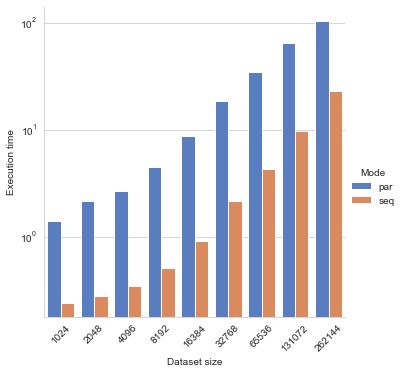

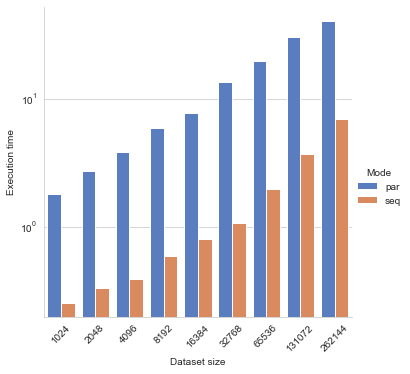

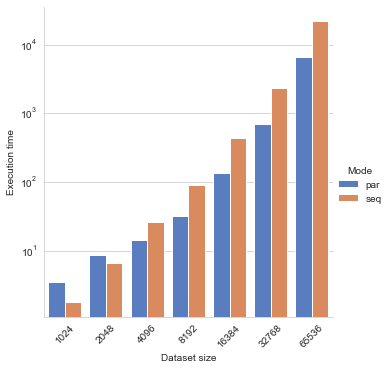

In [11]:
for feat_type in par_seq_df["Feat type"].unique():

    sns.set_style("whitegrid")

    # bar plot no of nodes on x,exec time in seconds on y, legends num instances
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=par_seq_df.loc[par_seq_df["Feat type"] == feat_type] , kind="bar",
        errorbar=None,
        x="Size", y="trainTime", hue="Mode",
        legend="full", palette="muted")

    g.set(yscale="log")

    # plt.title(f"Performance with {feat_type} features")

    plt.xticks(rotation=45)
    g.set_axis_labels("Dataset size", "Execution time")
    g.legend.set_title("Mode")

    g.figure.savefig(f"{plots_dir}seq_par_{feat_type}_BAR.png", dpi=1200, bbox_inches='tight')

    plt.show()

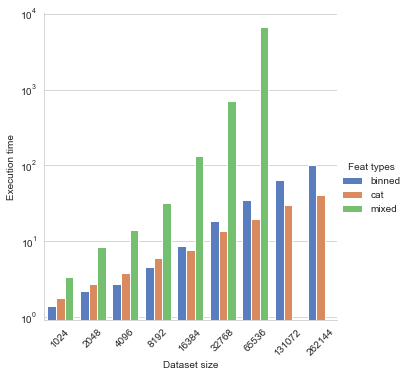

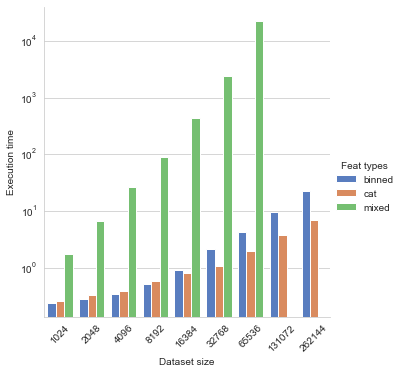

In [12]:
for mode in par_seq_df["Mode"].unique(): 
    sns.set_style("whitegrid")

    # bar plot no of nodes on x,exec time in seconds on y, legends num instances
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=par_seq_df.loc[par_seq_df["Mode"] == mode] , kind="bar",
        errorbar=None,
        x="Size", y="trainTime", hue="Feat type",
        legend="full", palette="muted")

    g.set(yscale="log")

    plt.xticks(rotation=45)

    g.set_axis_labels("Dataset size", "Execution time")
    g.legend.set_title("Feat types")

    g.figure.savefig(f"{plots_dir}{mode}_BAR.png", dpi=1200, bbox_inches='tight')

    plt.show()

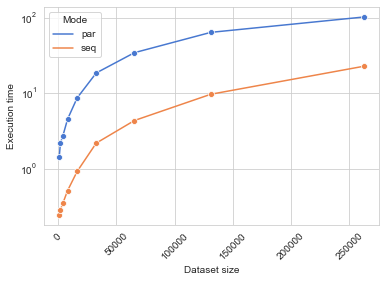

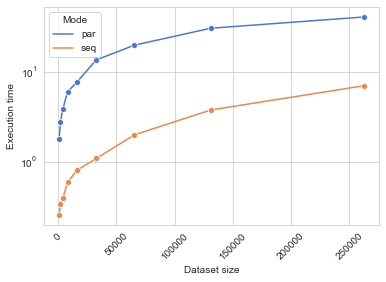

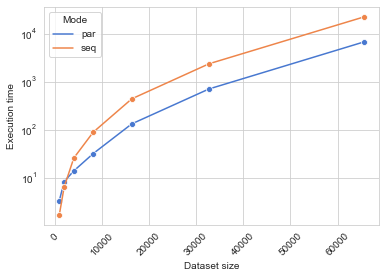

In [13]:
for feat_type in par_seq_df["Feat type"].unique():
    g = sns.lineplot(
        data=par_seq_df.loc[par_seq_df["Feat type"] == feat_type],
        x="Size", y="trainTime", hue="Mode",
        legend="full",
        palette= "muted",
        marker="o"
        )

    g.set(yscale="log")
    
    plt.xticks(rotation=45)
    
    g.figure.savefig(f"{plots_dir}seq_par_{feat_type}_LINE.png", dpi=1200, bbox_inches='tight')

    g.set_ylabel("Execution time")
    g.set_xlabel("Dataset size")

    plt.show()

## Scalability performance -  main algorithm (4)

Performance on different numbers of nodes with specific sample

In [14]:
# dist_df_1 - base
# dist_df_2 - with cache
# dist_df_3 - with cache, less features and similar to paper
# dist_df_4 - main (as version 3 + entropy sequential)

main_sizes = [  1024,   2048,   4096,   8192,
        16384,  32768,  65536, 131072,
       262144]

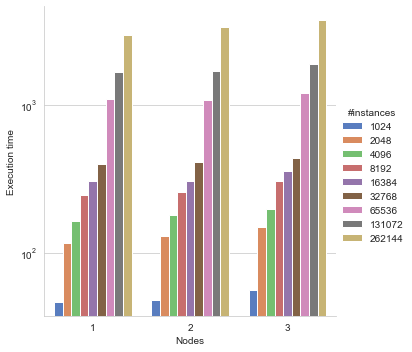

In [15]:
sns.set_style("whitegrid")

# bar plot no of nodes on x,exec time in seconds on y, legends num instances
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=dist_df_4.loc[dist_df_4["Size"].isin(main_sizes)], kind="bar",
    x="Workers", y="trainTime", hue="Size",
    legend="full", palette="muted")

g.set(yscale="log")

g.set_axis_labels("Nodes", "Execution time")
g.legend.set_title("#instances")

g.figure.savefig(f"{plots_dir}dist_4_BAR.png", dpi=1200, bbox_inches='tight')

plt.show()

Performance for different sample size on different numbers of nodes

In [16]:
workers = [ int(worker) for worker in dist_df_4["Workers"].unique()]
workers.sort()

workers

[1, 2, 3]

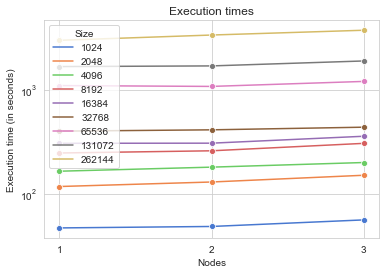

In [17]:
# bar plot no of nodes on x,exec time in seconds on y, legends num instances
# Draw a nested barplot by species and sex

g = sns.lineplot(
    data=dist_df_4.loc[dist_df_4["Size"].isin(main_sizes)],
    x="Workers", y="trainTime", hue="Size",
    legend="full",
    palette= "muted",
    marker="o"
    )

g.set(yscale="log")

g.set_xticks(range(1, len(workers) +1)) # <--- set the ticks first

plt.title("Execution times")

g.set_ylabel("Execution time (in seconds)")
g.set_xlabel("Nodes")

g.figure.savefig(f"{plots_dir}dist_4_LINE.png", dpi=1200, bbox_inches='tight')

plt.show()

Comparison mapreduce versions

1 WORKER

In [18]:
dist_df_1.sort_values(by=["Size", "Workers"])

dist_df_1["version"] = 1
dist_df_2["version"] = 2
dist_df_3["version"] = 3
dist_df_4["version"] = 4

In [19]:
cols = ["Size", "Workers", "trainTime", "version"]

dist_train_ds = pd.concat([dist_df_1[cols], dist_df_2[cols], dist_df_3[cols], dist_df_4[cols]])

In [20]:
dist_train_ds = dist_train_ds.reset_index()

In [21]:
dist_train_ds = dist_train_ds.loc[dist_train_ds["Size"].isin(main_sizes)]

In [22]:
dist_train_ds

,index,Size,Workers,trainTime,version
0,0,1024,1,80.397949,1
1,1,1024,2,91.735759,1
2,2,1024,3,113.031211,1
6,6,2048,1,222.465692,1
7,7,2048,2,231.318699,1
...,...,...,...,...,...
196,43,131072,2,1689.472213,4
197,44,131072,3,1884.872822,4
201,48,262144,1,2972.924035,4
202,49,262144,2,3341.834399,4


In [23]:
dist_train_ds.loc[dist_train_ds["Workers"]== 3].loc[dist_train_ds["trainTime"] != "Failed"]

,index,Size,Workers,trainTime,version
2,2,1024,3,113.031211,1
8,8,2048,3,311.146347,1
14,14,4096,3,428.216269,1
20,20,8192,3,799.265763,1
26,26,16384,3,1665.569932,1
32,32,32768,3,4958.030383,1
38,38,65536,3,16196.914425,1
44,44,131072,3,56668.485429,1
53,2,1024,3,62.352802,2
59,8,2048,3,141.274212,2


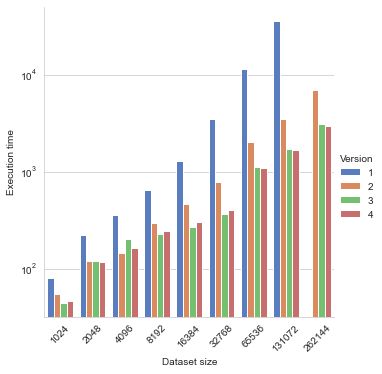

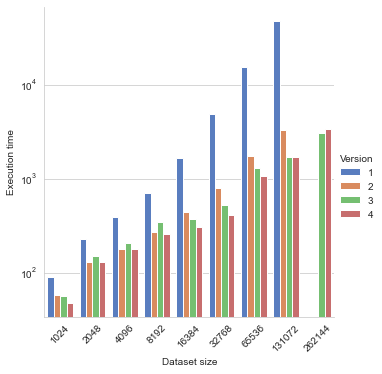

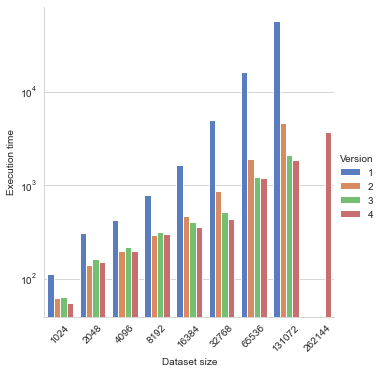

In [24]:
for worker in dist_train_ds["Workers"].unique():    
    sns.set_style("whitegrid")

    # bar plot no of nodes on x,exec time in seconds on y, legends num instances
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=dist_train_ds.loc[dist_train_ds["Workers"]== worker].loc[~dist_train_ds["trainTime"].isin(["Failed", "X"])], kind="bar",
        x="Size", y="trainTime", hue="version",
        legend="full", palette="muted")

    g.set(yscale="log")

    plt.xticks(rotation=45)

    g.set_axis_labels("Dataset size", "Execution time")
    g.legend.set_title("Version")

    g.figure.savefig(f"{plots_dir}dist_{worker}_workers_BAR.png", dpi=1200, bbox_inches='tight')

    plt.show()

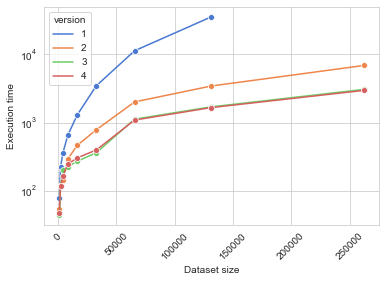

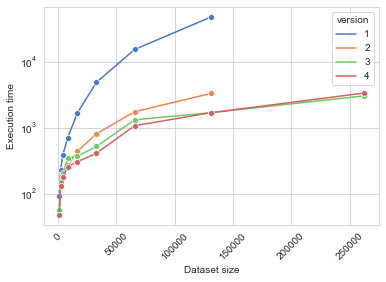

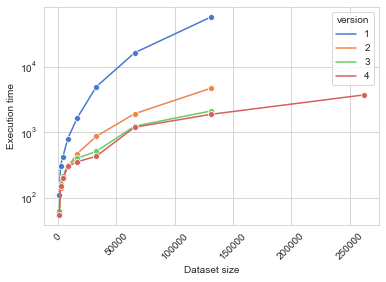

In [25]:
# bar plot no of nodes on x,exec time in seconds on y, legends num instances
# Draw a nested barplot by species and sex
for worker in dist_train_ds["Workers"].unique():
    g = sns.lineplot(
        data=dist_train_ds.loc[dist_train_ds["Workers"]== worker].loc[~dist_train_ds["trainTime"].isin(["Failed", "X"])],
        x="Size", y="trainTime", hue="version",
        legend="full",
        palette= "muted",
        marker="o"
        )

    g.set(yscale="log")

    plt.xticks(rotation=45)

    g.set_xlabel("Dataset size")
    g.set_ylabel("Execution time")
    
    g.figure.savefig(f"{plots_dir}dist_{worker}_workers_LINE.png", dpi=1200, bbox_inches='tight')

    plt.show()

Weak scalability

dataset + workers +

In [26]:
dist_train_ds

,index,Size,Workers,trainTime,version
0,0,1024,1,80.397949,1
1,1,1024,2,91.735759,1
2,2,1024,3,113.031211,1
6,6,2048,1,222.465692,1
7,7,2048,2,231.318699,1
...,...,...,...,...,...
196,43,131072,2,1689.472213,4
197,44,131072,3,1884.872822,4
201,48,262144,1,2972.924035,4
202,49,262144,2,3341.834399,4


In [27]:
weak_df =dist_df_4[["Size", "Workers", "trainTime"]].set_index(["Size", "Workers"])

sizes_w = [[
    (1024, 1),
    (2048, 2),
    (3413, 3),
]
,[
    (4096,  1),
    (8192,  2),
    (13653, 3),
]
,[
    (16384, 1),
    (32768, 2),
    (54613, 3),
]
,[
    (65536,  1),
    (131072, 2),
    (218453, 3)
]]

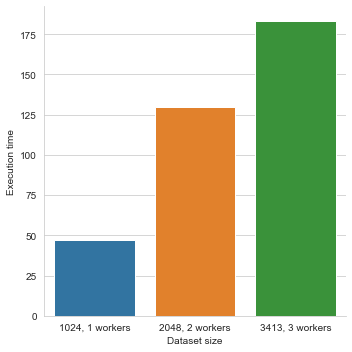

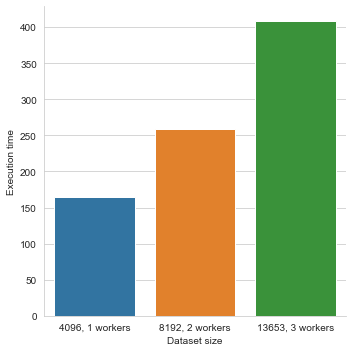

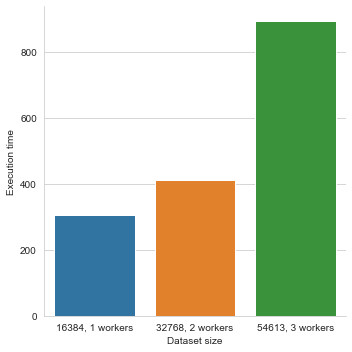

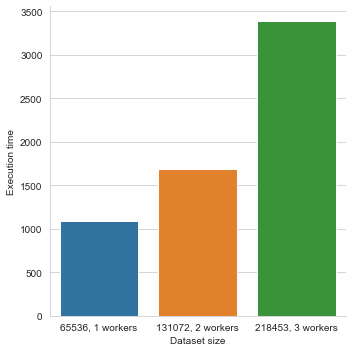

In [28]:
for sw_indices in sizes_w:
    tmp_df = weak_df.loc[sw_indices, :].reset_index()
    
    sns.set_style("whitegrid")

    # bar plot no of nodes on x,exec time in seconds on y, legends num instances
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=tmp_df.loc[~tmp_df["trainTime"].isin(["Failed", "X"])], kind="bar",
        x="Size", y="trainTime",
        legend="full")

    g.set_xticklabels([f"{s_w[0]}, {s_w[1]} workers" for s_w in sw_indices])
    g.set_axis_labels("Dataset size", "Execution time")

    g.figure.savefig(f"{plots_dir}dist_weak_scalability_{sw_indices[0][0]}_{sw_indices[0][1]}BAR.png", dpi=1200, bbox_inches='tight')

    plt.show()

    

Strong Scalability

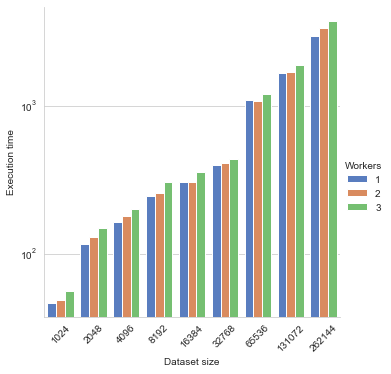

In [29]:
sns.set_style("whitegrid")

# bar plot no of nodes on x,exec time in seconds on y, legends num instances
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=dist_df_4.loc[dist_df_4["Size"].isin(main_sizes)].loc[~dist_df_4["trainTime"].isin(["Failed", "X"])], kind="bar",
    x="Size", y="trainTime", hue="Workers",
    legend="full", palette="muted")

g.set(yscale="log")

plt.xticks(rotation=45)

g.set_axis_labels("Dataset size", "Execution time")
g.legend.set_title("Workers")

g.figure.savefig(f"{plots_dir}dist_strong_scalability_BAR.png", dpi=1200, bbox_inches='tight')

plt.show()